### ShaneAO September 2023 Photonic Lantern Test: Guide to Running Experiments

Aditya Sengupta

In [1]:
%load_ext autoreload
%autoreload 2

First, check that this import works! If not, make sure you're on Python 3.8.15 in `~/projects/photonics/.venv/`.

In [2]:
import PySpin

If you ever run into issues with PySpin, search for PySpinDoc.pdf on this computer for their full documentation. For examples of how to use PySpin, check out `~/projects/shanepl/Examples`.

In [61]:
import photonics
import numpy as np
from matplotlib import pyplot as plt
try:
    import imageio.v3 as iio
except ModuleNotFoundError:
    import imageio as iio

I've put everything related to the PL project in this Python module. The principal objects you'll need to interact with are the `LanternReader` and `ShaneLantern`. If all goes well, you can just run every cell in this notebook with no or minimal changes and we'll get all the necessary data, but I'm making this a more comprehensive guide in case something needs to be adapted on the spot.

A `LanternReader` handles converting PL images to arrays of intensities; doing this on the fly is essential to closing the loop in our next on-sky test. It does this by reading in one image and identifying the bright spots with `photutils.DAOStarFinder`.

In [23]:
reader = photonics.LanternReader(
    nports = 18, # number of ports
    fwhm = 18, # the full width at half max of the lantern spots; feeds into DAOStarFinder
    threshold = 10, # threshold number of SDs to be above the background; feeds into DAOStarFinder
    ext = "npy", # the kind of file we want to write to
    imgshape = (1200, 1920), # the shape of the camera images we're writing
    subdir = None # the subdirectory of "data" we write to; defaults to "pl_YYMMDD".
)
reader.save_intensities = False # for 2023-11-01/02 Lick run; want full images.

Path for data saving set to /Users/adityasengupta/projects/photonics/data/pl_231101


A `ShaneLantern` is mostly just a collection of the functions I wrote on our last observing run, to get the actual images, send commands to the DM, and combine these to run more involved experiments.

In [11]:
lantern = photonics.ShaneLantern(
    reader = reader,
    Nmodes = 12 # the number of Zernike modes we can put on the DM
)

Num detected = 0
Found 0 cameras where 1 was expected; aborting.


### Calibrating the Lantern

The first thing to do is get an image we can use to find the centroids.

255

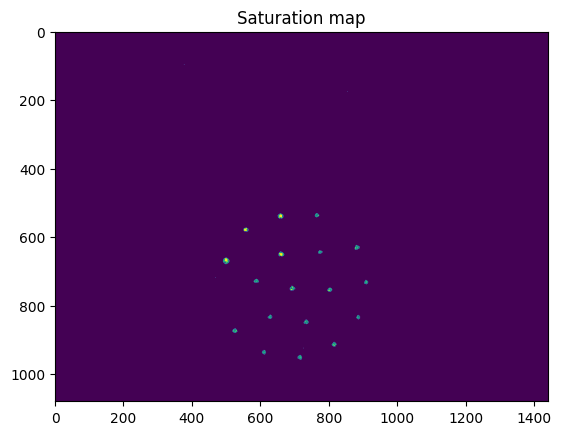

In [69]:
onsky = False # flip this on sky!
if onsky:
    # since we don't really care about speed
    # set the exposure time as high as possible with minimal saturation
    # so that this is an average and centroid detection isn't skewed by background
    img = lantern.get_image()
    print(img)
else:
    img = iio.imread("./data/pl_231028/ImageEvents-22087937-0.jpg")

reader.saturation = np.iinfo(img.dtype).max
reader.saturation_map(img)

You can repeatedly run the cell above to see a map of where the camera is saturating - based on last time, it'll probably be necessary to try a few different exposure times/settings till you get one you're happy with.

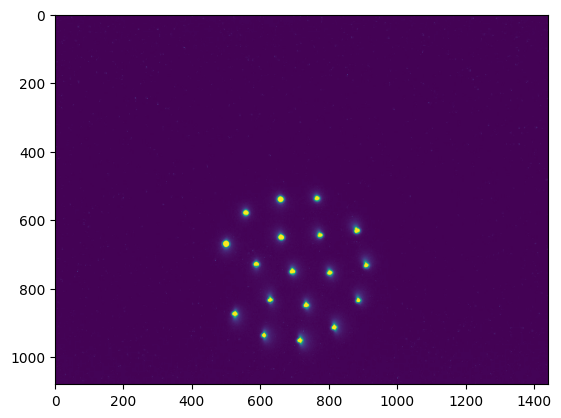

In [21]:
plt.imshow(img)

In [29]:
reader.fwhm = 35

In [33]:
reader.set_centroids(img) # will take a few seconds

At this point, you can plot the identified port positions. You don't have to save this every time, but it'll be helpful to have saved at least once, so we know which port is which index in the intensity arrays later.

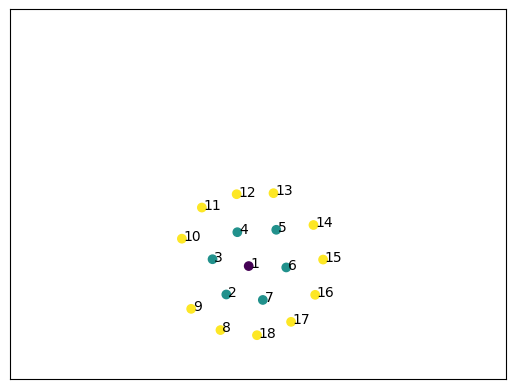

In [34]:
reader.plot_ports(save=True)

If this doesn't look like what you expect (quite likely), it's possible the background or the magnification on the detector are very different than what I've been seeing on SEAL. In this case, you can update `fwhm` or `threshold` to accommodate this.

As a last resort, if no settings seem to work with this, you can set `reader.save_intensities` to `False`. This will prompt the functions that run experiments to save full images instead of the intensity arrays, but in this case you'll need to keep an eye on storage.

You can also use the port mask to "mask out" any image you see, and set any pixel that isn't being read out as one of the intensities to 0:

In [38]:
reader.save_intensities = False

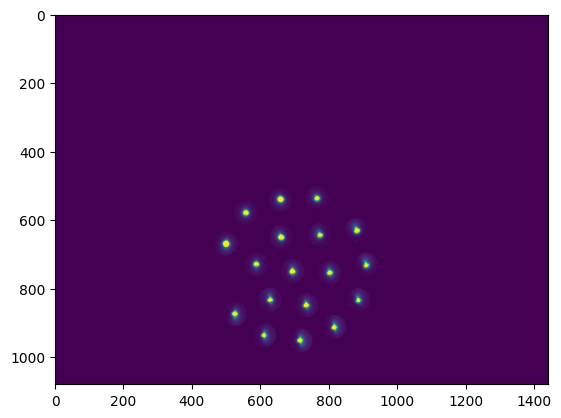

In [39]:
plt.imshow(img * reader.port_mask())

Finally, when this looks okay, you can read intensities off images using these settings:

In [40]:
reader.get_intensities(img) # an Nports-length array

array([121132., 107013., 103717., 122880.,  99473., 112861., 116316.,
       108433., 118756., 147653., 109500., 126527.,  99984., 116517.,
       110321.,  99453., 119634., 127337.])

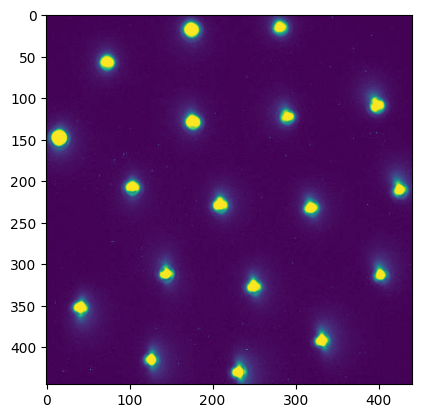

In [44]:
plt.imshow(reader.crop_to_bounding_box(img, pad=15))

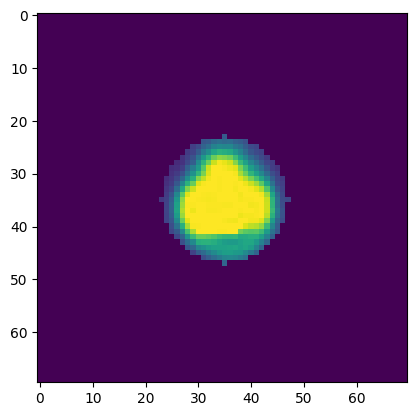

In [62]:
r = 35
x0, y0 = int(reader.xc[0]), int(reader.yc[0])
xl, xu = x0 - r, x0 + r
yl, yu = y0 - r, y0 + r

reader.fwhm = 12
plt.imshow((img * reader.port_mask())[yl:yu,xl:xu])

In [63]:
np.max(img)

255

### Daytime Testing

How do we actually use this? This is where the `ShaneLantern` object comes in. The basic functions are `command_to_dm` and `get_image`. We keep track of the current DM command in `lantern.curr_dmc`, and can update it to put new patterns on.

In [16]:
lantern.command_to_dm()

DMC 0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0.


/Users/adityasengupta/projects/photonics/photonics/shane.py:48: UserWarning: If you see this and you're at Lick, uncomment the lines defining and running shell_command.
  warnings.warn("If you see this and you're at Lick, uncomment the lines defining and running shell_command.")


In [17]:
img = lantern.get_image()

Not implemented, waiting on PySpin API


The interface to PySpin can be confusing, so if this doesn't work, try the following:

- check the SpinView GUI for errors
- run `python3 photonics/flir.py` - this is a barely-adapted version of one of their example scripts, so if there's an error with the camera in this code, it should show up when you run this script too
- run `lantern.deinitialize_camera()` and `lantern.initialize_camera()` - this runs through several PySpin setup steps again and may solve some issues
- the old-fashioned method: just restart the script and the camera

This is pretty cumbersome, so here's some more directly useful functions:

In [18]:
lantern.zern_to_dm(2, 1.0)

DMC 0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0.


As a safeguard against flipping the order (z, amp), it also checks the input types:

In [19]:
lantern.zern_to_dm(2, 1)
# do I mean amp = 1.0 on Zernike 2, or 2.0 on Zernike 1?

AssertionError: second argument must be a float (amplitude)

Combining these two functions lets us run more involved experiments. The easiest one of these is sending a probe signal.

In [20]:
lantern.probe_signal()

100%|██████████| 1/1 [00:00<00:00,  1.02it/s]


More generally, we're running instances of `lantern.experiment`, which takes in a collection of commands (a 2D array of size (Npatterns, Nmodes) in which each row is a DM command). I've provided the experiments I'm interested in, and if there's any reason to do anything else, you can adapt those functions!

In [21]:
lantern.sweep_mode(2) # sweep over a Zernike mode: can set min_amp, max_amp, and step

100%|██████████| 21/21 [00:15<00:00,  1.38it/s]


In [22]:
lantern.sweep_all_modes(step=0.25) # can set min_amp, max_amp, and step here too

Sweeping mode 1


100%|██████████| 9/9 [00:06<00:00,  1.36it/s]


Sweeping mode 2


100%|██████████| 9/9 [00:05<00:00,  1.51it/s]


Sweeping mode 3


100%|██████████| 9/9 [00:06<00:00,  1.49it/s]


Sweeping mode 4


100%|██████████| 9/9 [00:06<00:00,  1.44it/s]


Sweeping mode 5


100%|██████████| 9/9 [00:06<00:00,  1.45it/s]


Sweeping mode 6


100%|██████████| 9/9 [00:05<00:00,  1.51it/s]


Sweeping mode 7


100%|██████████| 9/9 [00:05<00:00,  1.51it/s]


Sweeping mode 8


100%|██████████| 9/9 [00:06<00:00,  1.45it/s]


Sweeping mode 9


100%|██████████| 9/9 [00:06<00:00,  1.44it/s]


Sweeping mode 10


100%|██████████| 9/9 [00:07<00:00,  1.26it/s]


Sweeping mode 11


100%|██████████| 9/9 [00:05<00:00,  1.51it/s]


Sweeping mode 12


100%|██████████| 9/9 [00:05<00:00,  1.53it/s]


In [23]:
lantern.sweep_mode_combinations()

100%|██████████| 77/77 [00:48<00:00,  1.59it/s]


In [24]:
lantern.random_combinations(10) # run this with a few thousand iterations

100%|██████████| 10/10 [00:06<00:00,  1.51it/s]


In [25]:
lantern.random_combinations(10, lim=0.12) # run this with a few thousand iterations

100%|██████████| 10/10 [00:06<00:00,  1.54it/s]


Finally, when you're all done with a round of testing, run this:

In [ ]:
lantern.deinitialize_camera()

I'm not sure exactly what'll happen if you don't do this, but making sure you do it helps keep the system behaviour consistent.

### On-Sky Testing

Finally, for on-sky testing, we just want to save as many images as we can, and the times they were taken. This means not doing any intensity calculations until after the test, so that the rate is limited by the camera and not the intensity computation. This means we'll potentially have a large amount of memory being used while data collection is going on - keep an eye on this, and if it turns out to be a problem (e.g. crashing this notebook) we can go back to data collection via the GUI. The benefit of doing it here is we can save timestamps and accurately sync up the probe signal, but it's not too bad if this can't happen.

`lantern.onsky` takes in one parameter, the timeout in seconds. You should adjust this along with however long you're taking telemetry - about 250-300 was good last time. Another option is: you can interrupt the cell at any time, and it'll stop collecting data and move to measuring intensities and saving. But I'm providing both options because interrupting a Jupyter cell can be a little unreliable. (Also: only interrupt it once! If you interrupt twice, it'll stop the processing/saving part of the code.)

In [26]:
# DO run this here
lantern.onsky(400) # timeout in seconds

100%|██████████| 1/1 [00:00<00:00,  1.26it/s]
/Users/adityasengupta/projects/photonics/photonics/shane.py:133: UserWarning: If you see this and you're at Lick, delete the `sleep(0.1)` just below this.
  warnings.warn("If you see this and you're at Lick, delete the `sleep(0.1)` just below this.")


Breaking out of loop
Done collecting images


100%|██████████| 48/48 [00:31<00:00,  1.51it/s]

Saving data to /Users/adityasengupta/projects/photonics/data/pl_230821/timestamps_230821_102939_801785.npy
Saving data to /Users/adityasengupta/projects/photonics/data/pl_230821/pl_230821_102939_801785.npy


Separately from the lantern data collection, we need to send commands to let the system know to save telemetry data. The script below does this. DO NOT run this in the notebook: we need the notebook for lantern image collection and synchronization.

In [ ]:
# copy and paste this into an ipython window, separate from this notebook!
# do not run this here!
"""
from photonics.shane import save_telemetry
from tqdm import trange
for i in trange(3):
    # try this out with 3 first (daytime is okay), check with the support astronomer
    # and during the night, increase it to match the window you want to measure for
    # I had this at about 50 iterations x 5 seconds each last time
    save_telemetry(0.1)
"""

### tl;dr

- Run through this notebook and make sure the reader is picking up on the intensity pattern we actually want
- During daytime testing, run the experiment cells (probe signal, sweep all modes, sweep mode combinations, a few thousand random combinations with lim=1.0, a few thousand random combinations with lim=0.12)
- During on-sky testing, run the `onsky` function for data collection, then open up a different ipython window and run the cell just above this with the loop over `save_telemetry`. When that's done and you've double-checked with the support astronomer that telemetry files have been saved, terminate the cell with `onsky` (once!)